In [1]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, array_max, collect_set, explode
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import concurrent.futures

In [2]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("Apriori")\
    .getOrCreate()
sc=spark.sparkContext

23/05/08 18:21:00 WARN Utils: Your hostname, jimbo-G5-5587 resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface wlp0s20f3)
23/05/08 18:21:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/08 18:21:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df=pd.read_csv('data/output.csv')

In [4]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')

In [5]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224.0,US,52375.0
1,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000.0,2014-12-01 18:30:44,1205.0,successful,16.0,US,1205.0
2,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 06:42:58,12500.0,2013-03-09 06:42:58,12700.0,successful,100.0,US,12700.0
3,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17 14:11:32,250.0,2012-08-02 14:11:32,250.0,successful,7.0,US,250.0
4,1000072011,CMUK. Shoes: Take on Life Feet First.,Fashion,Fashion,USD,2013-12-30 07:06:11,20000.0,2013-11-25 07:06:11,34268.0,successful,624.0,US,34268.0


In [6]:
df.isnull().sum()

ID               0
name             3
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
pledged          0
state            0
backers          0
country          0
usd pledged      0
dtype: int64

In [7]:
# First, some data cleaning & preprocessing

# ! 1 - Drop the ID and name columns
df.drop(['ID', 'name', 'usd pledged'], axis=1, inplace=True)

# ! 2 - Drop any rows that have NaN values
df.dropna(inplace=True)

# ! 3 - Calculate the campaign duration in days as the difference between the deadline and launched columns
# ! then drop the deadline and launched columns
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['duration'] = (df['deadline'] - df['launched']).dt.days
df.drop(['deadline', 'launched'], axis=1, inplace=True)

# ! 4 - convert all strings to lowercase
df['category'] = df['category'].str.lower()
df['main_category'] = df['main_category'].str.lower()
df['currency'] = df['currency'].str.lower()

In [8]:
df.head()

,category,main_category,currency,goal,pledged,state,backers,country,duration
0,restaurants,food,usd,50000.0,52375.0,successful,224.0,US,35
1,food,food,usd,1000.0,1205.0,successful,16.0,US,20
2,indie rock,music,usd,12500.0,12700.0,successful,100.0,US,30
3,music,music,usd,250.0,250.0,successful,7.0,US,15
4,fashion,fashion,usd,20000.0,34268.0,successful,624.0,US,35


In [9]:
# One last prepcrocessing step: For any column with continuous values, convert the values to discrete values
# Using KMeans clustering with variable k
# How the value of k for every column is determined using the elbow method

# ! The following columns have continuous values:
# ! usd pledged, backers, duration, usd goal

In [10]:
km = KMeans(init='random', n_init=10, random_state=0)
k_range = range(2, 11)
# Create a KElbowVisualizer object for wss (distortion) metric
visualizer_wss = KElbowVisualizer(km, k=k_range, metric='distortion')

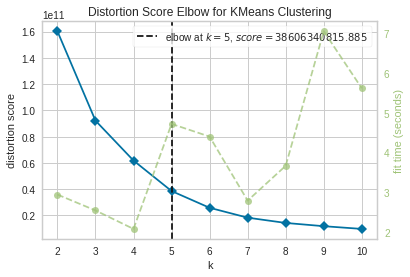

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# Fit the visualizer to the backers column and show the plot
visualizer_wss.fit(df['backers'].values.reshape(-1, 1))
backers_k = visualizer_wss.elbow_value_
visualizer_wss.show()

In [12]:
# Fit the visualizer to the pledged column and show the plot
visualizer_wss.fit(df['pledged'].values.reshape(-1, 1))
pledged_k = visualizer_wss.elbow_value_
visualizer_wss.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
# Fit the visualizer to the used goal column and show the plot
visualizer_wss.fit(df['goal'].values.reshape(-1, 1))
goal_k = visualizer_wss.elbow_value_
visualizer_wss.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Fit the visualizer to the duration column and show the plot
visualizer_wss.fit(df['duration'].values.reshape(-1, 1))
duration_k = visualizer_wss.elbow_value_
visualizer_wss.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Apply KMeans clustering to the backers column with the optimal value of k
km = KMeans(n_clusters=backers_k, init='random', n_init=10, random_state=0)
km.fit(df['backers'].values.reshape(-1, 1))
df['backers'] = km.labels_

In [16]:
# Apply KMeans clustering to the pledged column with the optimal value of k
km = KMeans(n_clusters=pledged_k, init='random', n_init=10, random_state=0)
km.fit(df['pledged'].values.reshape(-1, 1))
df['pledged'] = km.labels_

In [17]:
# Apply KMeans clustering to the goal column with the optimal value of k
km = KMeans(n_clusters=goal_k, init='random', n_init=10, random_state=0)
km.fit(df['goal'].values.reshape(-1, 1))
df['goal'] = km.labels_

In [18]:
# Apply KMeans clustering to the duration column with the optimal value of k
km = KMeans(n_clusters=duration_k, init='random', n_init=10, random_state=0)
km.fit(df['duration'].values.reshape(-1, 1))
df['duration'] = km.labels_

In [19]:
df.head()

,category,main_category,currency,goal,pledged,state,backers,country,duration
0,restaurants,food,usd,2,0,successful,0,US,3
1,food,food,usd,2,0,successful,0,US,1
2,indie rock,music,usd,2,0,successful,0,US,3
3,music,music,usd,2,0,successful,0,US,1
4,fashion,fashion,usd,2,0,successful,0,US,3


In [20]:
# Lastly, make sure that main_category and category values are consistent
df['category'].value_counts()

product design     19438
documentary        14588
music              12651
tabletop games     11937
shorts             11203
                   ...  
residencies           68
letterpress           47
chiptune              32
literary spaces       19
taxidermy              9
Name: category, Length: 159, dtype: int64

In [21]:
df['main_category'].value_counts()

film & video    56190
music           46051
publishing      35576
games           28798
technology      27676
design          26278
art             25801
food            22333
fashion         20195
theater         10198
comics           9917
photography      9737
crafts           7872
journalism       4198
dance            3605
Name: main_category, dtype: int64

In [22]:
# NOTE: The category column has 159 unique values, while the main_category column has 15 unique values
# ! We'll be applying the apriori algorithm twice, once with both main_category and category columns
# ! and once with only the main_category column to see which one yields better results

In [23]:
# Split the data into train and test
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

train['ID'] = train.index
test['ID'] = test.index

In [24]:
train = pd.melt(train, id_vars=["ID"], value_vars=["category", "main_category", "currency", "goal", "pledged", "state", "backers", "country", "duration"])
train.head(5)

,ID,variable,value
0,261585,category,food
1,234826,category,documentary
2,152746,category,journalism
3,186061,category,indie rock
4,320702,category,live games


In [25]:
train = train.drop(columns=["variable"])
train.head(5)

,ID,value
0,261585,food
1,234826,documentary
2,152746,journalism
3,186061,indie rock
4,320702,live games


In [26]:
train = train.rename(columns={"value": "item"})
train.head(5)

,ID,item
0,261585,food
1,234826,documentary
2,152746,journalism
3,186061,indie rock
4,320702,live games


In [27]:
train["item"] = train["item"].astype(str)
train = train.pivot_table(index="ID", columns="item", aggfunc=lambda x: 1, fill_value=0)
train.head(5)

item,0,1,2,3,3d printing,4,AT,AU,BE,CA,...,wearables,weaving,web,webcomics,webseries,woodworking,workshops,world music,young adult,zines
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
test = pd.melt(test, id_vars=["ID"], value_vars=["category", "main_category", "currency", "goal", "pledged", "backers", "country", "duration"])
test = test.drop(columns=["variable"])
test["value"] = test["value"].astype(str)
test = test.rename(columns={"value": "item"})
test = test.pivot_table(index="ID", columns="item", aggfunc=lambda x: 1, fill_value=0)

In [31]:
frequent_itemsets = apriori(train, min_support=0.1, use_colnames=True)

/home/jimbo/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [32]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

In [33]:
def predict(row):
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            return list(rule['consequents'])[0]
    return np.nan

In [39]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    test['prediction'] = list(executor.map(predict, test.itertuples(index=False)))

In [43]:
test['prediction']

ID
1        NaN
4        NaN
21       NaN
22       NaN
27       NaN
          ..
334405   NaN
334412   NaN
334415   NaN
334416   NaN
334417   NaN
Name: prediction, Length: 66885, dtype: float64

In [40]:
accuracy = (test['prediction'] == test['state']).mean()

KeyError: 'state'